Analyze 15/162-182 neq switching

In [1]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import tqdm
import warnings
warnings.filterwarnings('ignore')
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole
import pandas as pd
import pickle

In [2]:
def bound_with_exp(forward_accumulated, reverse_accumulated):
    upper_dg, upper_ddg = pymbar.exp.EXP(forward_accumulated)
    lower_dg, lower_ddg = pymbar.exp.EXP(reverse_accumulated)
    return upper_dg, upper_ddg, lower_dg, lower_ddg
    
def analyze(forward_accumulated, reverse_accumulated): 
    # Compute dg, ddg
    dg, ddg = pymbar.bar.BAR(forward_accumulated, reverse_accumulated)
    return dg, ddg

def analyze_bootstrap(d_works):
    d_dgs_phase = {}
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    d_dgs_phase['complex'] = (complex_dg, complex_ddg)
    d_dgs_phase['apo'] = (apo_dg, apo_ddg)
    
    binding_dg = complex_dg - apo_dg
#     binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
    return d_dgs_phase, binding_dg
    
def plot(forward_work, reverse_work, dg, ddg, dir_num, phase, output_dir, title):
#     # Substract offset
#     print("subtracting offset")
    forward_work_offset = []
    for cycle in forward_work:
        forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    forward_work_offset = np.array(forward_work_offset)

    reverse_work_offset = []
    for cycle in reverse_work:
        reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    reverse_work_offset = np.array(reverse_work_offset)

    # Plot work trajectories
    print("plotting work trajs")
    for cycle in forward_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = cycle
        plt.plot(x, y, color=sns.color_palette()[0])
    for cycle in reverse_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = -cycle
        plt.plot(x, y, color=sns.color_palette()[1])
    plt.xlabel("$t_{neq}$ (ns)")
    plt.ylabel("work (kT)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_traj.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_traj.png')}")
    plt.clf()
    
    # Plot work distributions
    print("plotting work distrib")
    accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
    accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
    sns.distplot(accumulated_forward)
    sns.distplot(accumulated_reverse)
    plt.axvline(dg)
    plt.axvline(dg + ddg, linestyle='dashed')
    plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
    plt.clf()

    return accumulated_forward
    

## 15/162

In [3]:
# Load data into dicts and plot 
titles = ["K417N"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 162
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 162
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/162/162_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/162/162_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/162/162_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/162/162_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 2.,  2., 12.,  9., 16., 21., 17., 12.,  6.,  3.]),
 array([-271.39063738, -269.13173724, -266.87283709, -264.61393695,
        -262.35503681, -260.09613667, -257.83723653, -255.57833638,
        -253.31943624, -251.0605361 , -248.80163596]),
 <BarContainer object of 10 artists>)

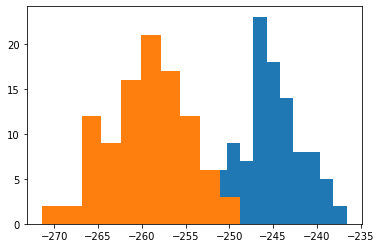

In [4]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [5]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [7]:
output_kcalmol

[1.18, (0.68, 1.69)]

In [8]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [10]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

In [11]:
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.2567003601406868

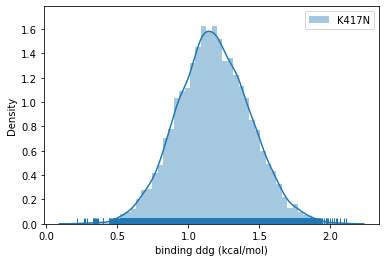

In [12]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## 15/163

In [13]:
# Load data into dicts and plot 
titles = ["E484K"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 163
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 163
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/163/163_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/163/163_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/163/163_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/163/163_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 1.,  0.,  1.,  5., 16., 15., 29., 24.,  6.,  3.]),
 array([-185.16262663, -183.40914049, -181.65565435, -179.90216821,
        -178.14868207, -176.39519593, -174.64170979, -172.88822365,
        -171.13473751, -169.38125137, -167.62776523]),
 <BarContainer object of 10 artists>)

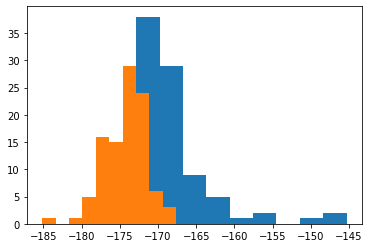

In [14]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [15]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [17]:
output_kcalmol

[-0.25, (-0.5, 0.01)]

In [18]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [19]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [20]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

In [21]:
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.12827020157443153

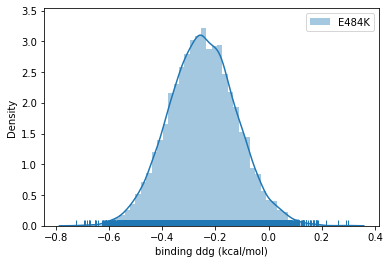

In [22]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## 15/164

In [23]:
# Load data into dicts and plot 
titles = ["L452R"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 164
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print("binding DDG: ", complex_dg*KT_KCALMOL - apo_dg*KT_KCALMOL, " (", ((apo_ddg**2 + complex_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("complex DG: ", complex_dg*KT_KCALMOL, " (", complex_ddg*KT_KCALMOL,")")
    print("apo DG: ", apo_dg*KT_KCALMOL, " (", apo_ddg*KT_KCALMOL,")")
    
    complex_upper_dg, complex_upper_ddg, complex_lower_dg, complex_lower_ddg = bound_with_exp(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_upper_dg, apo_upper_ddg, apo_lower_dg, apo_lower_ddg = bound_with_exp(d_works['apo']['forward'], d_works['apo']['reverse'])
    print("binding DDG (upper): ", complex_upper_dg*KT_KCALMOL - apo_upper_dg*KT_KCALMOL, " (", ((apo_upper_ddg**2 + complex_upper_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("complex DG: ", complex_upper_dg*KT_KCALMOL, " (", complex_upper_ddg*KT_KCALMOL,")")
    print("apo DG: ", apo_upper_dg*KT_KCALMOL, " (", apo_upper_ddg*KT_KCALMOL,")")
    print("binding DDG (lower): ", complex_lower_dg*-KT_KCALMOL - apo_lower_dg*-KT_KCALMOL, " (", ((apo_lower_ddg**2 + complex_lower_ddg**2)**0.5)*-KT_KCALMOL, ")")
    print("complex DG: ", complex_lower_dg*-KT_KCALMOL, " (", complex_lower_ddg*-KT_KCALMOL,")")
    print("apo DG: ", apo_lower_dg*-KT_KCALMOL, " (", apo_lower_ddg*-KT_KCALMOL,")")
    

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 164
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/164/164_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/164/164_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/164/164_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/164/164_apo_work_dist.png
binding DDG:  -0.19510831011379537  ( 0.14129532727002744 )
complex DG:  -236.1049351643801  ( 0.09948520445645885 )
apo DG:  -235.9098268542663  ( 0.1003347576994171 )
binding DDG (upper):  0.06347279134143946  ( 0.27283248871553417 )
complex DG:  -235.91431371954283  ( 0.1269273727788197 )
apo DG:  -235.97778651088427  ( 0.24150985267309202 )
binding DDG (lower):  -0.5033553652180274  ( -0.1981562838486942 )
complex DG:  -236.40618673735

<Figure size 432x288 with 0 Axes>

(array([ 1.,  3.,  5.,  3., 10., 14., 25., 19., 13.,  7.]),
 array([-405.60122346, -404.45319316, -403.30516286, -402.15713256,
        -401.00910226, -399.86107196, -398.71304166, -397.56501136,
        -396.41698106, -395.26895076, -394.12092046]),
 <BarContainer object of 10 artists>)

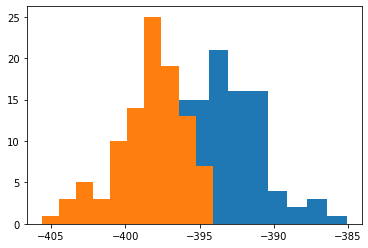

In [24]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [25]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [26]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [27]:
output_kcalmol

[-0.19, (-0.49, 0.11)]

In [28]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [29]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [30]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

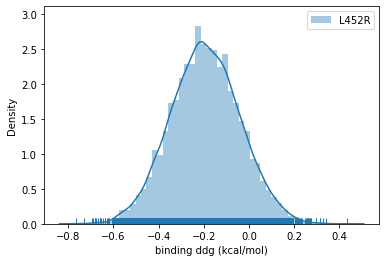

In [31]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [32]:
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.15225268121461677

In [33]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [34]:
output_kcalmol_apo

[-235.91, (-236.13, -235.69)]

In [35]:
output_kcalmol_complex

[-236.1, (-236.3, -235.89)]

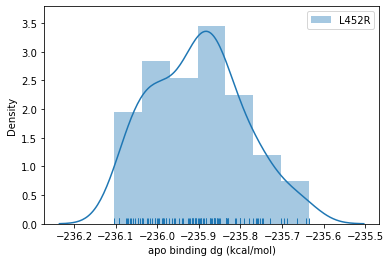

In [36]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

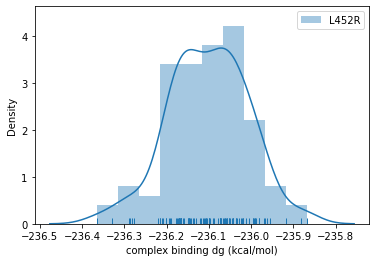

In [37]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/165

In [38]:
# Load data into dicts and plot 
titles = ["N439K"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 165
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print("binding DDG: ", complex_dg*KT_KCALMOL - apo_dg*KT_KCALMOL, " (", ((apo_ddg**2 + complex_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("\tcomplex DG: ", complex_dg*KT_KCALMOL, " (", complex_ddg*KT_KCALMOL,")")
    print("\tapo DG: ", apo_dg*KT_KCALMOL, " (", apo_ddg*KT_KCALMOL,")")
    
    complex_upper_dg, complex_upper_ddg, complex_lower_dg, complex_lower_ddg = bound_with_exp(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_upper_dg, apo_upper_ddg, apo_lower_dg, apo_lower_ddg = bound_with_exp(d_works['apo']['forward'], d_works['apo']['reverse'])
    print("binding DDG (upper): ", complex_upper_dg*KT_KCALMOL - apo_upper_dg*KT_KCALMOL, " (", ((apo_upper_ddg**2 + complex_upper_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("\tcomplex DG: ", complex_upper_dg*KT_KCALMOL, " (", complex_upper_ddg*KT_KCALMOL,")")
    print("\tapo DG: ", apo_upper_dg*KT_KCALMOL, " (", apo_upper_ddg*KT_KCALMOL,")")
    print("binding DDG (lower): ", complex_lower_dg*-KT_KCALMOL - apo_lower_dg*-KT_KCALMOL, " (", ((apo_lower_ddg**2 + complex_lower_ddg**2)**0.5)*-KT_KCALMOL, ")")
    print("\tcomplex DG: ", complex_lower_dg*-KT_KCALMOL, " (", complex_lower_ddg*-KT_KCALMOL,")")
    print("\tapo DG: ", apo_lower_dg*-KT_KCALMOL, " (", apo_lower_ddg*-KT_KCALMOL,")")
     

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 165
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/165/165_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/165/165_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/165/165_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/165/165_apo_work_dist.png
binding DDG:  0.9242005590804254  ( 0.24219538350028924 )
	complex DG:  -13.140630762320686  ( 0.18200730680032887 )
	apo DG:  -14.064831321401112  ( 0.15978718365420655 )
binding DDG (upper):  0.45050333482724625  ( 0.59427928605054 )
	complex DG:  -13.039326033838353  ( 0.5241491429795417 )
	apo DG:  -13.4898293686656  ( 0.2800634673472274 )
binding DDG (lower):  0.3442038989055547  ( -0.33308994106479944 )
	complex DG:  -14.315935888252

<Figure size 432x288 with 0 Axes>

(array([ 3.,  5., 12.,  7., 16., 14., 11., 15.,  9.,  8.]),
 array([-36.80163269, -35.24292104, -33.68420938, -32.12549773,
        -30.56678608, -29.00807442, -27.44936277, -25.89065112,
        -24.33193947, -22.77322781, -21.21451616]),
 <BarContainer object of 10 artists>)

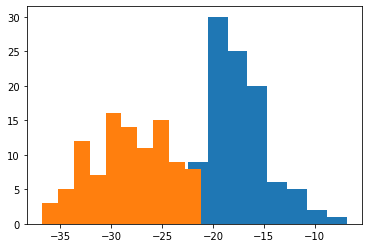

In [39]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [40]:
np.min(d_works['complex']['forward'])

-26.354019415609866

In [41]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [42]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [43]:
output_kcalmol

[0.92, (0.5, 1.32)]

In [44]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [45]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [46]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

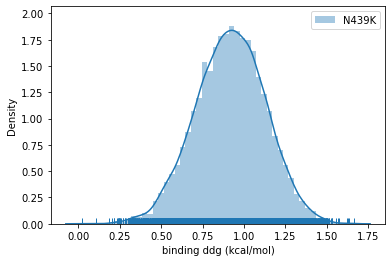

In [47]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [48]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.21132795024699774

In [49]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [50]:
output_kcalmol_apo

[-14.07, (-14.35, -13.78)]

In [51]:
output_kcalmol_complex

[-13.15, (-13.48, -12.87)]

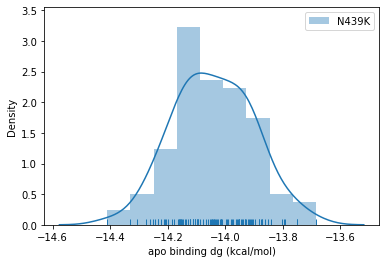

In [52]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

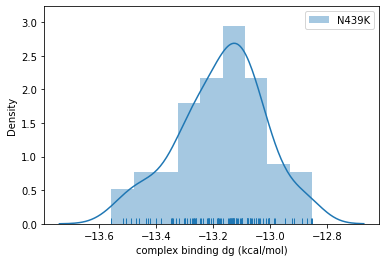

In [53]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/166

In [4]:
# Load data into dicts and plot 
titles = ["N501A"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 166
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 166
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/166/166_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/166/166_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/166/166_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/166/166_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

In [5]:
complex_dg - apo_dg

-0.13751740418092595

(array([ 2.,  3.,  8., 20., 23., 18.,  6.,  6., 11.,  3.]),
 array([104.1697933 , 107.24067105, 110.31154879, 113.38242654,
        116.45330428, 119.52418203, 122.59505977, 125.66593751,
        128.73681526, 131.807693  , 134.87857075]),
 <BarContainer object of 10 artists>)

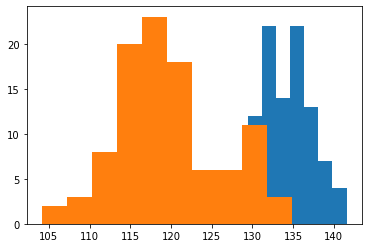

In [55]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [56]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [57]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [58]:
output_kcalmol

[-0.1, (-0.66, 0.39)]

In [59]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [60]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [61]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

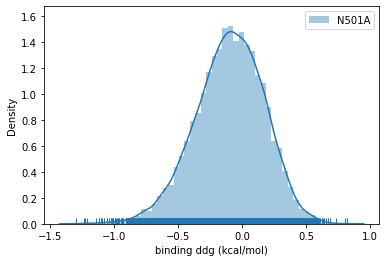

In [62]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [63]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.2685573568299002

In [64]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [65]:
output_kcalmol_apo

[77.35, (77.18, 77.52)]

In [66]:
output_kcalmol_complex

[77.25, (76.71, 77.71)]

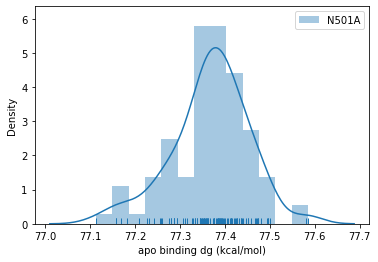

In [67]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

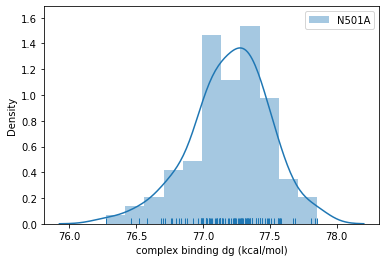

In [68]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/167

In [69]:
# Load data into dicts and plot 
titles = ["N501V"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 167
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 167
89
about to save: complex forward
89
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/167/167_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/167/167_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/167/167_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/167/167_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 5.,  1.,  6., 19.,  8., 19., 17.,  3.,  7.,  4.]),
 array([ 92.74242048,  94.67258668,  96.60275288,  98.53291907,
        100.46308527, 102.39325147, 104.32341766, 106.25358386,
        108.18375006, 110.11391625, 112.04408245]),
 <BarContainer object of 10 artists>)

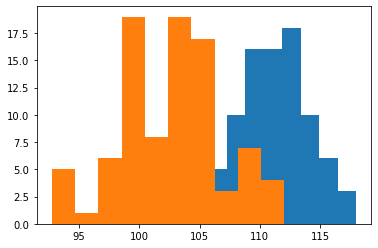

In [70]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [71]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [72]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [73]:
output_kcalmol

[0.38, (-0.1, 0.86)]

In [74]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [75]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [76]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

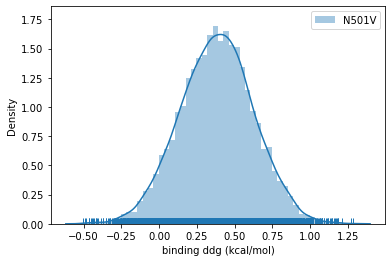

In [77]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [78]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.24353062623775587

In [79]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [80]:
output_kcalmol_apo

[63.59, (63.43, 63.75)]

In [81]:
output_kcalmol_complex

[63.97, (63.53, 64.42)]

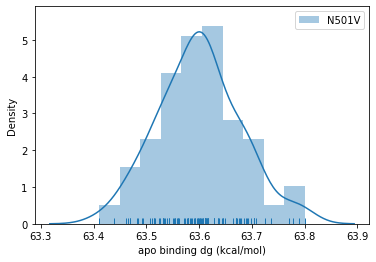

In [82]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

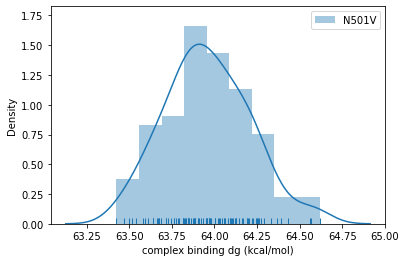

In [83]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/168

In [84]:
# Load data into dicts and plot 
titles = ["N501I"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 168
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 168
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/168/168_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/168/168_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/168/168_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/168/168_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 7.,  6., 15., 19., 19., 14.,  7.,  7.,  3.,  3.]),
 array([131.22723311, 132.95094783, 134.67466254, 136.39837725,
        138.12209196, 139.84580667, 141.56952138, 143.29323609,
        145.0169508 , 146.74066551, 148.46438022]),
 <BarContainer object of 10 artists>)

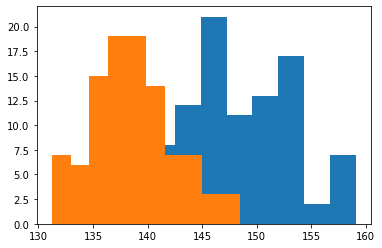

In [85]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [86]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [87]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [88]:
output_kcalmol

[1.25, (0.68, 1.84)]

In [89]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [90]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [91]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

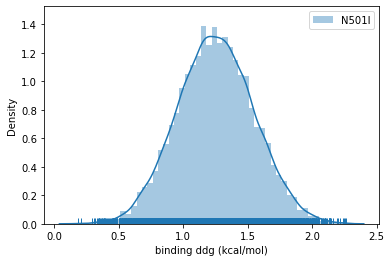

In [92]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [93]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.29586998638856365

In [94]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [95]:
output_kcalmol_apo

[83.69, (83.47, 83.91)]

In [96]:
output_kcalmol_complex

[84.94, (84.4, 85.48)]

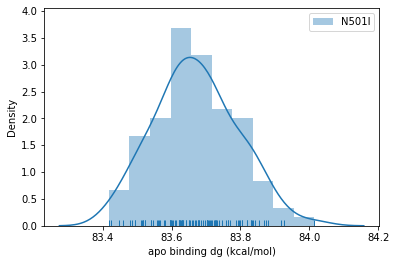

In [97]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

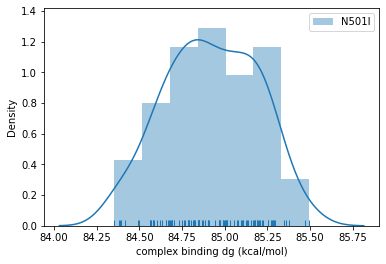

In [98]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/169

In [99]:
# Load data into dicts and plot 
titles = ["N501L"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 169
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 169
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/169/169_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/169/169_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/169/169_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/169/169_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 4., 11., 19., 22., 11., 13.,  6.,  6.,  7.,  1.]),
 array([ 95.02684482,  96.49041868,  97.95399254,  99.41756641,
        100.88114027, 102.34471413, 103.808288  , 105.27186186,
        106.73543572, 108.19900958, 109.66258345]),
 <BarContainer object of 10 artists>)

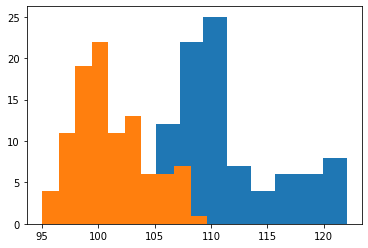

In [100]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [101]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [102]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [103]:
output_kcalmol

[1.28, (0.82, 1.72)]

In [104]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [105]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [106]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

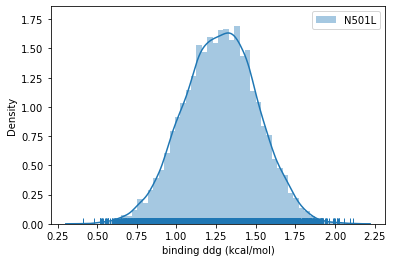

In [107]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [108]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.23293006330399862

In [109]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [110]:
output_kcalmol_apo

[61.54, (61.4, 61.68)]

In [111]:
output_kcalmol_complex

[62.82, (62.38, 63.25)]

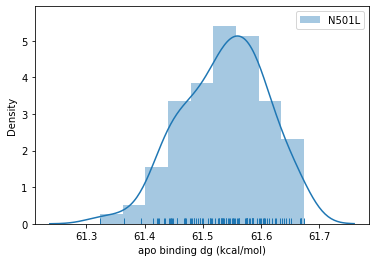

In [112]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

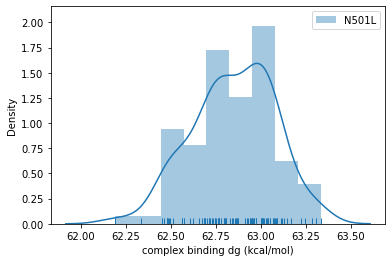

In [113]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/170

In [114]:
# Load data into dicts and plot 
titles = ["N501M"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 170
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 170
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/170/170_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/170/170_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/170/170_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/170/170_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 3.,  2., 10., 25., 20., 28.,  9.,  1.,  1.,  1.]),
 array([118.85015853, 121.07926473, 123.30837093, 125.53747713,
        127.76658334, 129.99568954, 132.22479574, 134.45390194,
        136.68300814, 138.91211435, 141.14122055]),
 <BarContainer object of 10 artists>)

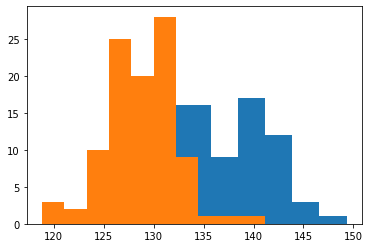

In [115]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [116]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [117]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [118]:
output_kcalmol

[-0.23, (-0.62, 0.17)]

In [119]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [120]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [121]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

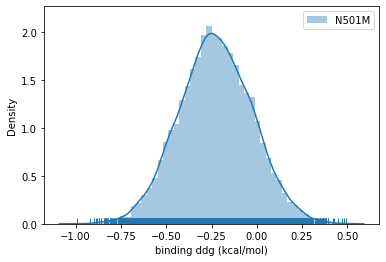

In [122]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [123]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.20131268183410764

In [124]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [125]:
output_kcalmol_apo

[78.23, (78.06, 78.39)]

In [126]:
output_kcalmol_complex

[78.0, (77.65, 78.36)]

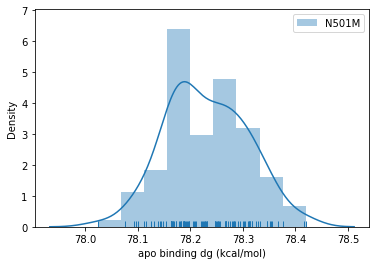

In [127]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

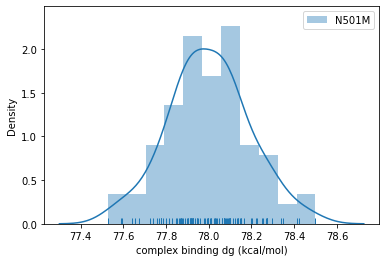

In [128]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/171

In [129]:
# Load data into dicts and plot 
titles = ["N501F"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 171
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 171
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/171/171_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/171/171_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/171/171_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/171/171_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 3.,  6., 18., 14., 18., 18., 15.,  4.,  2.,  2.]),
 array([125.79411112, 128.20211763, 130.61012413, 133.01813063,
        135.42613713, 137.83414363, 140.24215013, 142.65015663,
        145.05816314, 147.46616964, 149.87417614]),
 <BarContainer object of 10 artists>)

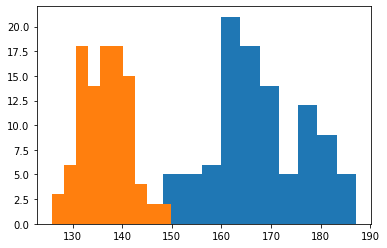

In [130]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [131]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [132]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [133]:
output_kcalmol

[1.27, (0.33, 2.26)]

In [134]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [135]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [136]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

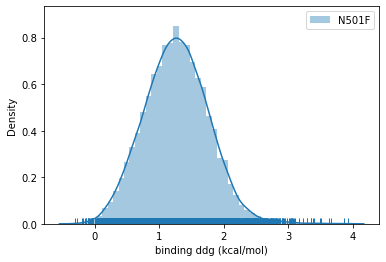

In [137]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [138]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.49853938319697716

In [139]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [140]:
output_kcalmol_apo

[87.24, (87.02, 87.45)]

In [141]:
output_kcalmol_complex

[88.51, (87.59, 89.47)]

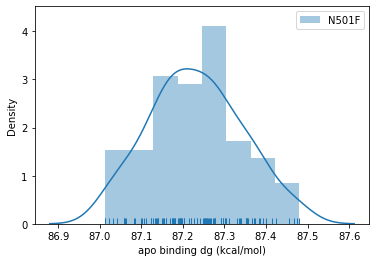

In [142]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

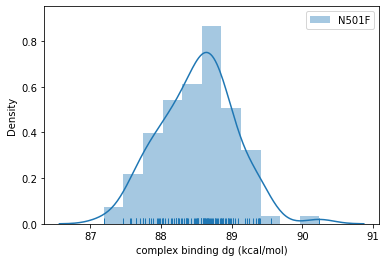

In [143]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/172

In [144]:
# Load data into dicts and plot 
titles = ["N501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 172
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 172
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/172/172_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/172/172_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/172/172_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/172/172_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 2.,  2.,  9., 12., 30., 15., 10., 11.,  4.,  5.]),
 array([ 85.17926219,  87.63089877,  90.08253534,  92.53417191,
         94.98580849,  97.43744506,  99.88908163, 102.34071821,
        104.79235478, 107.24399135, 109.69562793]),
 <BarContainer object of 10 artists>)

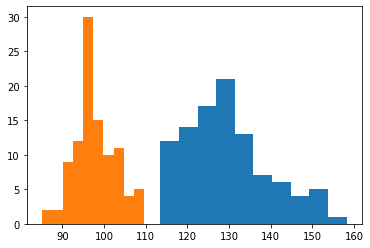

In [145]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [146]:
np.std(d_works['complex']['forward'])

9.990732289609504

In [147]:
np.std(d_works['complex']['reverse']*-1)

4.857522887466519

In [148]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [149]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [150]:
output_kcalmol

[0.3, (-0.24, 0.85)]

In [151]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [152]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [153]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

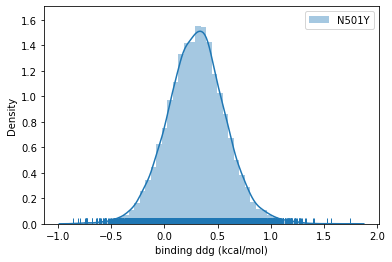

In [154]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [155]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.27638176810229975

In [156]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [157]:
output_kcalmol_apo

[66.1, (65.89, 66.32)]

In [158]:
output_kcalmol_complex

[66.41, (65.9, 66.91)]

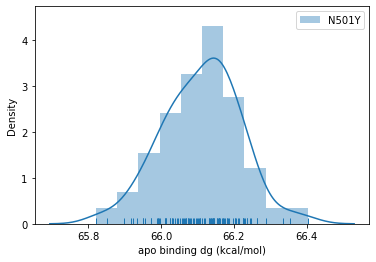

In [159]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

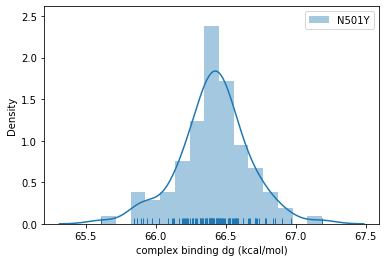

In [160]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/173

In [3]:
# Load data into dicts and plot 
titles = ["N501W"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 173
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 173
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/173/173_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/173/173_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/173/173_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/173/173_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 6.,  9., 14., 21., 15., 11.,  8.,  8.,  5.,  3.]),
 array([142.56770335, 144.61435628, 146.66100921, 148.70766214,
        150.75431507, 152.800968  , 154.84762093, 156.89427386,
        158.94092678, 160.98757971, 163.03423264]),
 <BarContainer object of 10 artists>)

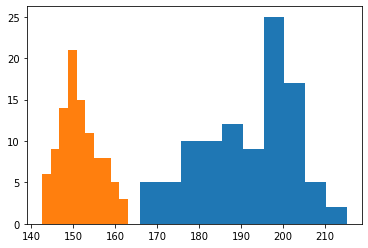

In [4]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [5]:
np.std(d_works['complex']['forward'])

11.242094725193375

In [6]:
np.std(d_works['complex']['reverse']*-1)

4.66360132229478

In [7]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [9]:
output_kcalmol

[4.37, (3.56, 5.2)]

In [10]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [11]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [12]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

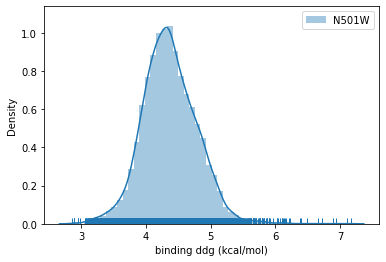

In [13]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [14]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.4237608958223819

In [15]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [16]:
output_kcalmol_apo

[94.0, (93.78, 94.22)]

In [17]:
output_kcalmol_complex

[98.36, (97.59, 99.18)]

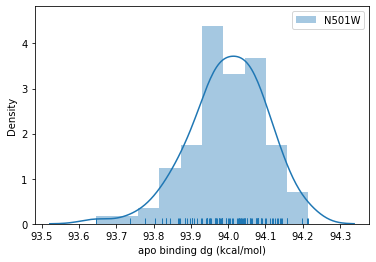

In [18]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

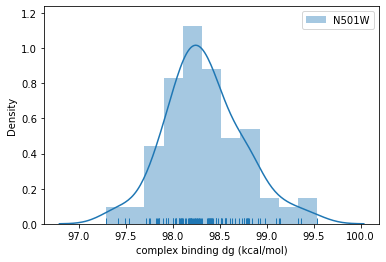

In [19]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()